In [1]:
pip install tensorflow librosa scikit-learn imbalanced-learn matplotlib


   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.4 MB/s eta 0:03:51
   ---------------------------------------- 0.8/332.0 MB 1.3 MB/s eta 0:04:13
   ---------------------------------------- 1.3/332.0 MB 1.7 MB/s eta 0:03:16
   ---------------------------------------- 1.6/332.0 MB 1.6 MB/s eta 0:03:24
   ---------------------------------------- 1.6/332.0 MB 1.6 MB/s eta 0:03:24
   ---------------------------------------- 1.6/332.0 MB 1.6 MB/s eta 0:03:24
   ---------------------------------------- 1.8/332.0 MB 1.1 MB/s eta 0:04:48
   ---------------------------------------- 2.4/332.0 MB 1.3 MB/s eta 0:04:08
   ---------------------------------------- 2.9/332.0 MB 1.4 MB/s eta 0:03:50
   ---------------------------------------- 3.4/332.0 MB 1.6 MB/s eta 0:03:31
   ---------------------------------------- 3.4/332.0 MB 1.6 MB/s eta 0:03:31


In [9]:
import os, numpy as np, librosa
from pathlib import Path
import matplotlib.pyplot as plt

# Set base paths
BASE_DIR = Path("C:/Users/prate/Downloads/College Academics/Minor Project/Minor Project")
DATA_DIR = BASE_DIR / "data"
SIREN_DIR = DATA_DIR / "siren"
NON_DIR = DATA_DIR / "non_siren"

# Confirm folders exist and contain .wav files
print("Siren folder exists:", SIREN_DIR.exists())
print("Non-siren folder exists:", NON_DIR.exists())
print("Siren files:", len(list(SIREN_DIR.glob("*.wav"))))
print("Non-siren files:", len(list(NON_DIR.glob("*.wav"))))


Siren folder exists: True
Non-siren folder exists: True
Siren files: 40
Non-siren files: 1960


In [10]:
SR = 22050
WIN_SEC = 1.5
HOP_SEC = 0.75
WIN = int(SR * WIN_SEC)
HOP = int(SR * HOP_SEC)

def extract_logmel(x, sr=SR, n_mels=64):
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=1024, hop_length=256, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S.astype(np.float32)

def file_to_logmel(path, label):
    x, sr = librosa.load(path.as_posix(), sr=SR, mono=True)
    if np.max(np.abs(x)) > 0: 
        x = x / np.max(np.abs(x))
    feats, labels = [], []
    if len(x) < WIN: 
        x = np.pad(x, (0, WIN - len(x)))
    for start in range(0, max(len(x) - WIN + 1, 1), HOP):
        seg = x[start:start+WIN]
        logmel = extract_logmel(seg)
        feats.append(logmel)
        labels.append(label)
    return np.stack(feats), np.array(labels)

# Build dataset
X_list, y_list = [], []

for p in SIREN_DIR.glob("*.wav"):
    fx, fy = file_to_logmel(p, 1)
    X_list.append(fx); y_list.append(fy)

for p in NON_DIR.glob("*.wav"):
    fx, fy = file_to_logmel(p, 0)
    X_list.append(fx); y_list.append(fy)

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
X = X[..., np.newaxis]  # Add channel dimension

print("ESC dataset shape:", X.shape, y.shape)


ESC dataset shape: (10000, 64, 130, 1) (10000,)


In [25]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from sklearn.model_selection import train_test_split

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, stratify=y, test_size=0.2, random_state=42
# )

# # Define lightweight CNN
# input_shape = X.shape[1:]

# model_esc = models.Sequential([
#     layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(32, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')
# ])

# model_esc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model_esc.summary()

# # Train
# history = model_esc.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

# # Evaluate
# test_loss, test_acc = model_esc.evaluate(X_test, y_test)
# print("ESC Test accuracy:", test_acc)


import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Define optimized CNN (same style as UrbanSound model)
input_shape = X.shape[1:]

model_esc = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_esc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_esc.summary()

# Train
history = model_esc.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

# Evaluate
test_loss, test_acc = model_esc.evaluate(X_test, y_test)
print("ESC Test accuracy:", test_acc)


c:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 130, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 130, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 65, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 16, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 16, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,433 (415.75 KB)

 Trainable params: 105,953 (413.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - accuracy: 0.9759 - loss: 0.0871 - val_accuracy: 0.9769 - val_loss: 0.1231
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.9828 - loss: 0.0526 - val_accuracy: 0.9787 - val_loss: 0.0772
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.9869 - loss: 0.0408 - val_accuracy: 0.9769 - val_loss: 0.1278
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.9891 - loss: 0.0333 - val_accuracy: 0.9825 - val_loss: 0.0676
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.9905 - loss: 0.0300 - val_accuracy: 0.9825 - val_loss: 0.0698
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.9909 - loss: 0.0256 - val_accuracy: 0.9875 - val_loss: 0.0365
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9959 - loss: 0.0165 - val_accuracy: 0.9862 - val_loss: 0.0587
Epoch 8/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.9937 - loss: 0

In [13]:
import pandas as pd

US8K_DIR = BASE_DIR / "datasets" / "UrbanSound8k" / "UrbanSound8K"
US8K_AUDIO = US8K_DIR / "audio"
US8K_META = US8K_DIR / "metadata" / "UrbanSound8K.csv"

# Load metadata
meta = pd.read_csv(US8K_META)
print(meta.head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [14]:
# Siren = label 1, everything else = label 0
meta['label'] = meta['class'].apply(lambda c: 1 if c == 'siren' else 0)

print(meta['class'].value_counts())
print("Total siren clips:", (meta['label'] == 1).sum())


class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64
Total siren clips: 929


In [15]:
X_list, y_list = [], []

for i, row in meta.iterrows():
    file_name = row["slice_file_name"]
    fold = row["fold"]
    label = row["label"]   # 1 for siren, 0 otherwise
    
    file_path = US8K_AUDIO / f"fold{fold}" / file_name
    if file_path.exists():
        fx, fy = file_to_logmel(file_path, label)
        X_list.append(fx); y_list.append(fy)

X_us = np.concatenate(X_list, axis=0)
y_us = np.concatenate(y_list, axis=0)
X_us = X_us[..., np.newaxis]

print("UrbanSound8K dataset shape:", X_us.shape, y_us.shape)


UrbanSound8K dataset shape: (31217, 64, 130, 1) (31217,)


In [24]:
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_us, y_us, stratify=y_us, test_size=0.2, random_state=42
# )

# input_shape = X_us.shape[1:]

# model_us = models.Sequential([
#     layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(32, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')
# ])

# model_us.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model_us.summary()

# # Train
# history_us = model_us.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# # Evaluate
# test_loss, test_acc = model_us.evaluate(X_test, y_test)
# print("UrbanSound8K Test accuracy:", test_acc)

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_us, y_us, stratify=y_us, test_size=0.2, random_state=42
)

input_shape = X_us.shape[1:]

model_us = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_us.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_us.summary()

# Train
history_us = model_us.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate
test_loss, test_acc = model_us.evaluate(X_test, y_test)
print("UrbanSound8K Test accuracy:", test_acc)



c:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 130, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 130, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 65, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 16, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 16, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,433 (415.75 KB)

 Trainable params: 105,953 (413.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 175ms/step - accuracy: 0.9446 - loss: 0.1568 - val_accuracy: 0.9566 - val_loss: 0.1152
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.9711 - loss: 0.0887 - val_accuracy: 0.9538 - val_loss: 0.1472
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.9804 - loss: 0.0628 - val_accuracy: 0.9678 - val_loss: 0.1022
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.9843 - loss: 0.0480 - val_accuracy: 0.9758 - val_loss: 0.0712
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.9861 - loss: 0.0410 - val_accuracy: 0.9758 - val_loss: 0.0697
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - accuracy: 0.9877 - loss: 0.0354 - val_accuracy: 0.9844 - val_loss: 0.0461
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.9908 - loss: 0.0284 - val_accuracy: 0.9099 - val_loss: 0.8270
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.9929 - loss

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


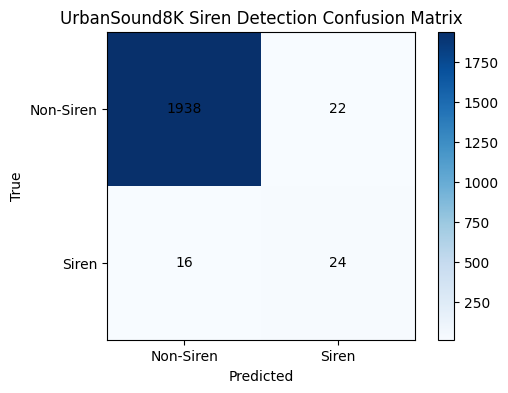

              precision    recall  f1-score   support

   Non-Siren       0.99      0.99      0.99      1960
       Siren       0.52      0.60      0.56        40

    accuracy                           0.98      2000
   macro avg       0.76      0.79      0.77      2000
weighted avg       0.98      0.98      0.98      2000



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = (model_us.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(cm, cmap="Blues")

# Show numbers
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Non-Siren","Siren"])
ax.set_yticklabels(["Non-Siren","Siren"])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("UrbanSound8K Siren Detection Confusion Matrix")
plt.colorbar(im)
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Non-Siren","Siren"]))


In [27]:
import os, numpy as np, pandas as pd, librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# --- Config ---
SR = 22050
WIN_SEC = 1.5
HOP_SEC = 0.75
WIN = int(SR * WIN_SEC)
HOP = int(SR * HOP_SEC)
N_MELS = 64

def extract_logmel(x, sr=SR, n_mels=N_MELS):
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=1024, hop_length=256, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S.astype(np.float32)

def file_to_logmel(path, label):
    x, sr = librosa.load(path, sr=SR, mono=True)
    if np.max(np.abs(x)) > 0: x = x / np.max(np.abs(x))
    feats, labels = [], []
    if len(x) < WIN: x = np.pad(x, (0, WIN - len(x)))
    for start in range(0, max(len(x) - WIN + 1, 1), HOP):
        seg = x[start:start+WIN]
        feats.append(extract_logmel(seg))
        labels.append(label)
    return np.stack(feats), np.array(labels)



In [33]:
# --- Dataset loaders ---
def load_siren_dataset(base_dir):
    X_list, y_list = [], []
    for cls in ["ambulance","firetruck","police"]:
        folder = os.path.join(base_dir, cls)
        for f in os.listdir(folder):
            if f.endswith(".wav"):
                fx, fy = file_to_logmel(os.path.join(folder,f), 1) # siren = 1
                X_list.append(fx); y_list.append(fy)
    # traffic as non-siren
    folder = os.path.join(base_dir, "traffic")
    for f in os.listdir(folder):
        if f.endswith(".wav"):
            fx, fy = file_to_logmel(os.path.join(folder,f), 0)
            X_list.append(fx); y_list.append(fy)
    return np.concatenate(X_list), np.concatenate(y_list)

# Example: load sireNNet
X_sirenNet, y_sirenNet = load_siren_dataset("datasets/sireNNet")
X_sirenSound, y_sirenSound = load_siren_dataset("datasets/Siren Sound Dataset")

# TODO: add UrbanSound8K and ESC loaders similarly (using metadata CSV for labels)

# --- Merge all ---
X_all = np.concatenate([X_sirenNet, X_sirenSound], axis=0)[..., np.newaxis]
y_all = np.concatenate([y_sirenNet, y_sirenSound], axis=0)



C:\Users\prate\AppData\Local\Temp\ipykernel_23476\2932157490.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(path, sr=SR, mono=True)


NoBackendError: 

In [32]:
import os, subprocess

def convert_dataset(base_dir):
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.lower().endswith(".wav"):
                src = os.path.join(root, f)
                dst = src.replace(".wav", "_fixed.wav")
                subprocess.run([
                    "ffmpeg", "-y", "-i", src,
                    "-ar", "22050", "-ac", "1", "-c:a", "pcm_s16le", dst
                ])

convert_dataset(r"C:\Users\prate\Downloads\College Academics\Minor Project\Minor Project\datasets\Siren Sound Dataset")


In [ ]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, test_size=0.2, random_state=42
)

# --- Optimized CNN ---
input_shape = X_all.shape[1:]
model_siren = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_siren.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_siren.summary()

# --- Train ---
history = model_siren.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# --- Evaluate ---
test_loss, test_acc = model_siren.evaluate(X_test, y_test)
print("Unified Siren Model Test accuracy:", test_acc)
